In [74]:
from manifold_learning import CCM
from manifold_learning.data.data_loader import load_csv_dataset, load_ld2011_2014_dataset, load_traffic_dataset
from manifold_learning.utils import utils
import importlib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.integrate import solve_ivp
importlib.reload(CCM)
importlib.reload(utils)
import time

In [75]:
import torch
torch.cuda.empty_cache()

In [19]:
X = load_traffic_dataset()
X = X[X.columns[1:]]

df = X.T

# Interpolate missing values
df_interpolated = df.interpolate(method='linear', limit_direction='forward', axis=0)

# Fill any remaining missing values with zeros
df_filled = df_interpolated.fillna(0)
X = df_filled.to_numpy().astype(np.float32)


X = np.log(X+1)
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X = X[:,X.mean(axis=0) != 0]
X = (X-X.mean(axis=0))/X.std(axis=0)

mask = (np.count_nonzero(np.diff(X[:,:],axis=0),axis=0) > 750)
X = X[:,mask]

In [112]:
def lorenz(t, state, sigma, beta, rho):
    x, y, z = state
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    return [dxdt, dydt, dzdt]

In [3]:
def get_lorenz_rand(tmax = 140, n_steps = 10000, sigma=10, beta=8/3, rho=28):
    initial_state = np.random.normal(size=(3))

    trunc = int(n_steps/tmax * 40) # Number of steps to get independence from initial conditions
    t_eval = np.linspace(0, tmax, trunc + n_steps)

    solution = solve_ivp(lorenz, (0, tmax), initial_state, args=(sigma, beta, rho), t_eval=t_eval).y.T[trunc:]
    return solution

In [45]:
X_emb = np.transpose(utils.get_td_embedding_np(get_lorenz_rand(280,n_steps=30000),5,20,return_pred=False),axes=(2,0,1))

In [190]:
X_emb = np.concatenate([np.transpose(utils.get_td_embedding_np(get_lorenz_rand(280,rho=10+3*i,n_steps=30000),4,20,return_pred=False),axes=(2,0,1)) for i in range(50)])
X_emb.shape

(150, 29940, 4)

In [86]:
ccm = CCM.CCM(device="cpu")

In [102]:
X_emb = np.transpose(utils.get_td_embedding_np(X[:,0:200],3,1),(2,0,1)).astype(np.float32)
Y_emb = np.transpose(utils.get_td_embedding_np(X[:,0:200],3,1),(2,0,1)).astype(np.float32)

In [135]:
X_emb = np.concatenate([np.array([utils.get_td_embedding_np(X[:,[0]],i,j)[:,:,0] for i in range(1,10)],dtype=object) for j in range(1,10)])

In [105]:
X_emb = X_emb[:,:-1]
Y_emb = Y_emb[:,1:]

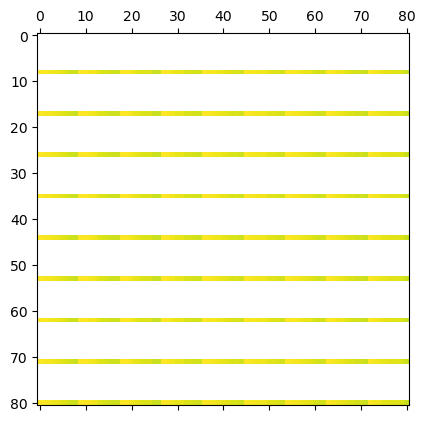

In [136]:
plt.matshow(ccm.compute(X_emb,X_emb[:],600,200,10,10,0)[-1],vmax=1,vmin=0)

In [28]:
100000 * 100000 / (300 * 300)

111111.11111111111

In [29]:
(111111 * 116)/1000

12888.876

In [27]:
%%timeit
ccm.compute(X_emb,X_emb[:],600,100,20,10,1)[-1]

214 ms ± 2.72 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [197]:
%%timeit
ccm.compute(X_emb,X_emb[:,:,0:2],1000,200,10,10,10)[-1]

258 ms ± 32.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [198]:
%%timeit
ccm.compute(X_emb,X_emb[:,:,0:3],1000,200,10,10,10)[-1]

326 ms ± 5.22 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [199]:
%%timeit
ccm.compute(X_emb,X_emb[:,:,:],1000,200,40,10,10)[-1]

351 ms ± 4.67 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
